Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Part 3: Fitting a variational auto-encoder

In the last part of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [76]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='./data', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

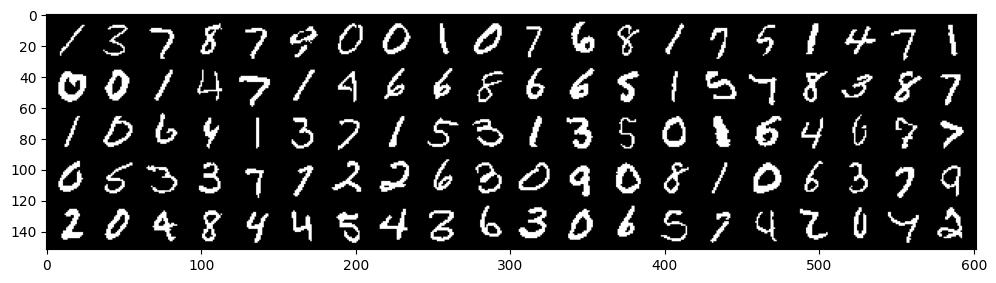

In [77]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points (extra credit) if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [78]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        #
        # Later on in the `.forward` method, you then can call this.
        #
        # Some ``useful'' layers include:
        #
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

        # YOUR CODE HERE
        # NN
        self.net = nn.Linear(28 * 28, 400)
        self.net_mu = nn.Linear(400, D_latent)
        self.net_logstdev = nn.Linear(400, D_latent)

        # # CNN
        # self.net = nn.Sequential(
        #     nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),            
        #     nn.ReLU(),
        # )
        # self.net_mu = nn.Linear(64 * 7 * 7, D_latent)
        # self.net_logstdev = nn.Linear(64 * 7 * 7, D_latent)
        

        

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        
        batch_size = X.shape[0]

        # NN
        X_flat = X.reshape(batch_size, -1)
        
        # Pass through shared layer
        h = torch.relu(self.net(X_flat))

        # # CNN
        # h = self.net(X)
        # h = h.reshape(h.shape[0], -1)  
        
        # Get mean and logstdev
        mu = self.net_mu(h)
        logstdev = self.net_logstdev(h)
        
        # Convert standard deviation
        sigma = torch.exp(logstdev)

        assert mu.shape == (X.shape[0], self.D_latent)
        assert mu.shape == sigma.shape
        return dist.Normal(mu, sigma)


In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define your networks here
        
        # YOUR CODE HERE
        # NN
        self.net = nn.Sequential(
            nn.Linear(D_latent, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28)
        )

        # # CNN
        # self.net = nn.Sequential(
        #     nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        # )
        # self.projection_net = nn.Linear(D_latent, 64 * 7 * 7)
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """

        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        # YOUR CODE HERE
        batch_size = Z.shape[0]
        
        # NN
        # # Pass through network
        logits = self.net(Z)
        
        # Reshape to image dimensions
        logits = logits.reshape(batch_size, 1, 28, 28)

        # # CNN
        # h = self.projection_net(Z)
        # h = h.reshape(batch_size, 64, 7, 7)
        # logits = self.net(h)
        
        # Return Bernoulli distribution (for binary MNIST images)
        return dist.Bernoulli(logits=logits)



### The following assertions should all pass, if your return types are correct:

In [80]:
# The encoder should return a distribution
assert isinstance(Encoder(D_latent=10)(X_random_batch), dist.Distribution)

# Encoding a batch should give a (batch_size, D_latent) matrix as output
assert Encoder(D_latent=5)(X_random_batch).sample().shape == (X_random_batch.shape[0], 5)

# Encoding and decoding should recover entries with the same dimensionality as the data
assert Decoder(D_latent=10)(Encoder(D_latent=10)(X_random_batch).sample()).sample().shape == X_random_batch.shape


AttributeError: 'Decoder' object has no attribute 'projection_net'

# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [ ]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """

    # YOUR CODE HERE
    batch_size = X.shape[0]
    
    # encoder distribution q(z|x)
    q_z_given_x = enc(X)
    
    # reparameterization trick
    z = q_z_given_x.rsample() # single sample
    
    # decoder distribution p(x|z)
    p_x_given_z = dec(z)
    
    # reconstruction term E_q[log p(x|z)]
    log_p_x_given_z = p_x_given_z.log_prob(X).sum(dim=[1, 2, 3])  # Sum over image dimensions
    # Because of reparameterization trick, this is equivalent to using E_q[log p(x|z)] in expectation ONLY 
    # - but this is sufficient for SGD/Adam, as the new expectation is over gaussian noise
    
    # KL divergence: KL(q(z|x) || p(z))
    # prior z ~ N(0, I)
    p_z = dist.Normal(torch.zeros_like(z), torch.ones_like(z))
    
    # KL divergence for diagonal Gaussians
    kl_div = dist.kl_divergence(q_z_given_x, p_z).sum(dim=1)  # Sum over latent dimensions
    
    # single sample ELBO = reconstruction - KL
    ss_elbo = log_p_x_given_z - kl_div
    
    assert ss_elbo.shape == (batch_size,)
    
    return ss_elbo

# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [ ]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [ ]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [ ]:
# ignore this cell (placeholder)


In [ ]:
# Running longer might give better results, 
# but if everything is working you should see good progress by 10 epochs
N_epochs = 10
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 14918.6690
Epoch 1, train loss = 10959.1704
Epoch 2, train loss = 10384.4728
Epoch 3, train loss = 10090.3125
Epoch 4, train loss = 9891.4430
Epoch 5, train loss = 9749.4614
Epoch 6, train loss = 9637.5719
Epoch 7, train loss = 9550.8501
Epoch 8, train loss = 9483.0774
Epoch 9, train loss = 9421.6335


## Do reconstructions look like the input?

Reconstruction accuracy: 0.94


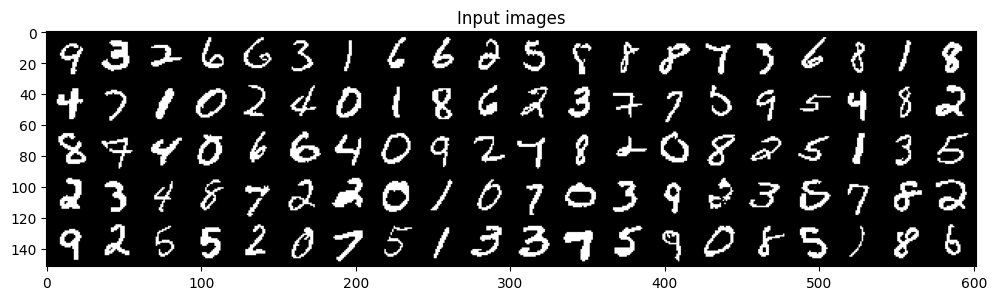

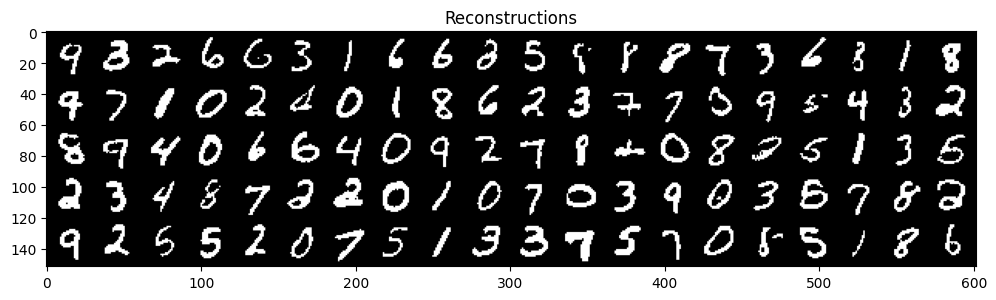

In [ ]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

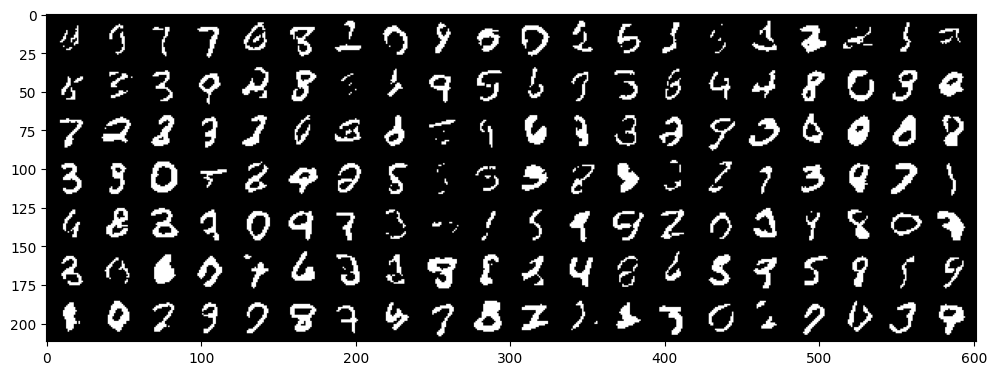

In [ ]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

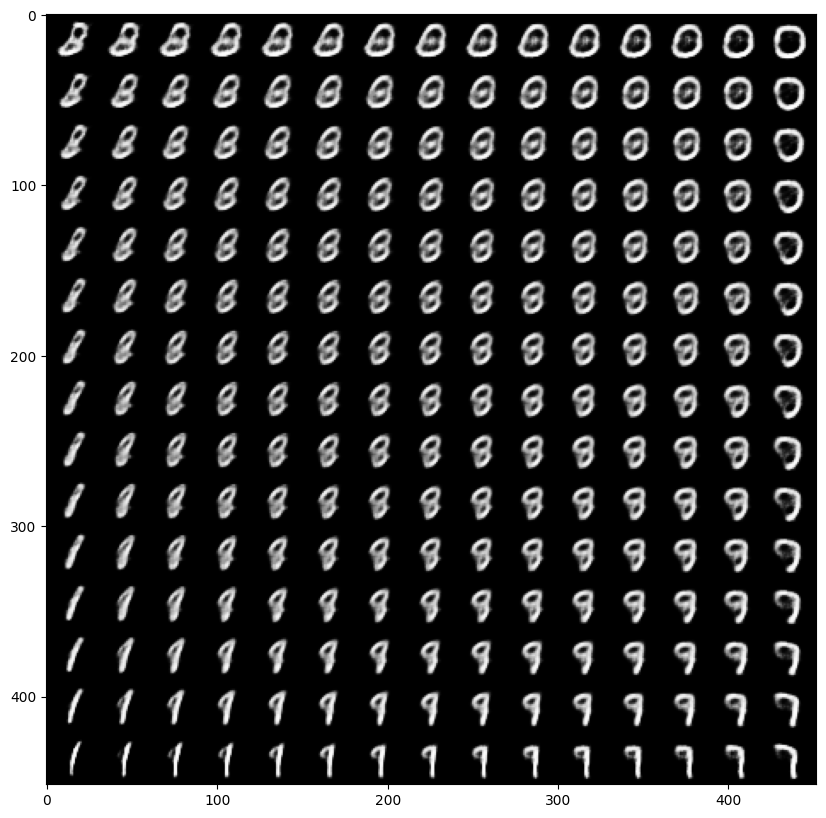

In [ ]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points, indexing='ij')
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading


In [ ]:
# grading
